Codigo Adaptado del tutorial: https://github.com/intel-analytics/BigDL-Tutorials/blob/master/notebooks/neural_networks/cnn.ipynb

In [6]:
import os
import numpy as np


# Lista archivos en el directorio de entrada
#input_files = os.listdir('/workspace/input')
#print("Archivos en /workspace/input:", input_files)

In [7]:
from __future__ import print_function
import numpy as np
from bigdl.nn.keras.topology import Sequential
from bigdl.nn.keras.layer import *

In [8]:
from bigdl.nn.criterion import *

In [14]:
import numpy as np
from pyspark import SparkConf, SparkContext
from bigdl.nn.layer import *
from bigdl.optim.optimizer import *
from bigdl.util.common import init_engine, Sample
import datetime as dt
from sklearn.model_selection import train_test_split

In [11]:
import matplotlib

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from pyspark import SparkContext
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))

init_engine()

## SESSION SPARK

In [2]:
import pyspark
print("PySpark version:", pyspark.__version__)

PySpark version: 2.4.3


In [22]:
# Ruta a los archivos .npy
images_path = '/workspace/input/stage2_imagenes.npy'
masks_path = '/workspace/input/stage2_etiquetas.npy'

# Cargar los archivos .npy
train_images = np.load(images_path)
train_masks = np.load(masks_path)

# Verificar las dimensiones de los datos cargados
print(f"train_images shape: {train_images.shape}")
print(f"train_masks shape: {train_masks.shape}")

train_images shape: (5663, 28, 28, 3)
train_masks shape: (5663, 2)


In [23]:
# Convertir etiquetas de one-hot a índices de clase y ajustar el rango a [1, 2]
train_masks = np.argmax(train_masks, axis=1).astype('int64') + 1

# Verificar la conversión
print(f"train_masks shape after conversion: {train_masks.shape}")  # (5663,)
print(f"train_masks unique values: {np.unique(train_masks)}")  

train_masks shape after conversion: (5663,)
train_masks unique values: [1 2]


In [24]:
# b. Reordenar ejes de las imágenes de (N, H, W, C) a (N, C, H, W)
train_images = train_images.transpose(0, 3, 1, 2).astype('float32') / 255.0

print(f"train_images transposed shape: {train_images.shape}")  # (5663, 3, 28, 28)

# c. Dividir en conjuntos de entrenamiento y validación
train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

print(f"train_imgs shape: {train_imgs.shape}")  # (4530, 3, 28, 28)
print(f"train_lbls shape: {train_lbls.shape}")  # (4530,)
print(f"val_imgs shape: {val_imgs.shape}")      # (1133, 3, 28, 28)
print(f"val_lbls shape: {val_lbls.shape}")      # (1133,)

# 3. Inicializar Spark y BigDL
conf = SparkConf().setAppName("LenetTraining").setMaster("local[*]")  # Ajusta según tu entorno
sc = SparkContext.getOrCreate(conf=conf)
init_engine()


train_images transposed shape: (5663, 3, 28, 28)
train_imgs shape: (4530, 3, 28, 28)
train_lbls shape: (4530,)
val_imgs shape: (1133, 3, 28, 28)
val_lbls shape: (1133,)


## MODELO CNN

In [16]:
def build_model(class_num):
    model = Sequential()
    # Cambiamos el número de canales de entrada a 3
    model.add(Reshape([3, 28, 28]))
    # Ajustamos el número de canales de entrada en la primera capa convolucional
    model.add(SpatialConvolution(3, 6, 5, 5).set_name('conv1'))
    model.add(Tanh())
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
    model.add(Tanh())
    model.add(SpatialConvolution(6, 12, 5, 5).set_name('conv2'))
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))
    model.add(Reshape([12 * 4 * 4]))
    model.add(Linear(12 * 4 * 4, 100).set_name('fc1'))
    model.add(Tanh())
    # Cambiamos el número de clases de salida a 2
    model.add(Linear(100, class_num).set_name('score'))
    model.add(LogSoftMax())
    return model

# Construimos el modelo con 2 clases de salida
lenet_model = build_model(2)


creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax


In [25]:
# 4. Crear RDDs de muestras

def to_sample(image, label):
    return Sample.from_ndarray(image, label)

train_rdd = sc.parallelize(zip(train_imgs, train_lbls)).map(lambda x: to_sample(x[0], x[1])).cache()
val_rdd = sc.parallelize(zip(val_imgs, val_lbls)).map(lambda x: to_sample(x[0], x[1])).cache()


In [26]:
# 6. Configurar el Optimizer con batch_size=40
optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_rdd,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=0.01, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(20),
    batch_size=40
)

# Configurar la lógica de validación con batch_size=40
optimizer.set_validation(
    batch_size=40,
    val_rdd=val_rdd,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy


In [27]:
# Configurar los resúmenes de entrenamiento y validación
app_name = 'lenet-' + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                             app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)

print("Saving logs to", app_name)

creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
Saving logs to lenet-20241120-144539


In [28]:
# 7. Entrenar el modelo
trained_model = optimizer.optimize()

In [34]:
# 8. Guardar el modelo entrenado
trained_model.save(f"/workspace/output/{app_name}_lenet_model")
print(f"Modelo guardado en /workspace/output/{app_name}_lenet_model")

Modelo guardado en /workspace/output/lenet-20241120-144539_lenet_model


In [30]:
params = trained_model.parameters()

In [31]:
params

{'conv2': {'weight': array([[[[[-0.04853564, -0.03264995,  0.04482485, -0.06065768,
              0.0128796 ],
            [ 0.07349522, -0.06930362,  0.02323649, -0.0136313 ,
              0.00530781],
            [ 0.06388167, -0.02629312,  0.03893083,  0.01211294,
             -0.00295856],
            [ 0.03833746,  0.06893666, -0.02133596, -0.03623065,
              0.05403404],
            [ 0.034915  , -0.07591644, -0.07922169, -0.00052828,
             -0.06244498]],
  
           [[ 0.00108795,  0.07301218, -0.0017273 , -0.05172611,
              0.07807806],
            [ 0.02846659,  0.06890958,  0.06866153,  0.03937826,
              0.02016015],
            [-0.06550348, -0.07334215,  0.03913598, -0.00767837,
              0.0641968 ],
            [-0.0711588 ,  0.009929  , -0.01241181,  0.06526646,
             -0.02487542],
            [ 0.0055016 ,  0.07631223, -0.06013873,  0.04848846,
              0.02735407]],
  
           [[-0.00625123, -0.06088461,  0.00924332, -

In [32]:
#batch num, output_dim, input_dim, spacial_dim
for layer_name, param in params.items():
    print(layer_name,param['weight'].shape,param['bias'].shape)

conv2 (1, 12, 6, 5, 5) (12,)
fc1 (100, 192) (100,)
conv1 (1, 6, 3, 5, 5) (6,)
score (2, 100) (2,)


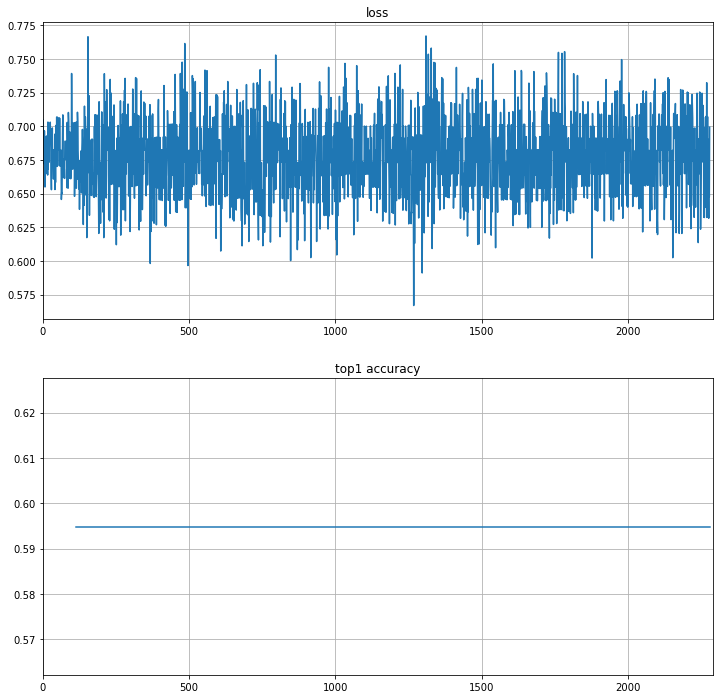

In [33]:
## Loss Visualization
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)

In [37]:
# Inspeccionar un ejemplo de Sample
example_sample = val_rdd.first()
print(dir(example_sample))
print(example_sample)


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'bigdl_type', 'feature', 'features', 'from_jtensor', 'from_ndarray', 'label', 'labels']
Sample: features: [JTensor: storage: [9.6493814e-06 1.1760183e-05 1.1217405e-05 ... 1.1157096e-05 9.1669126e-06
 9.8906157e-06], shape: [ 3 28 28], float], labels: [JTensor: storage: [1.], shape: [1], float],


In [57]:
# 9. Generar Predicciones sobre el Conjunto de Validación

# Pasa el RDD completo de Samples al método predict
val_predictions_rdd = trained_model.predict(val_rdd)

# Extraer las predicciones (features) del RDD resultante
val_predictions = val_predictions_rdd.collect()

# Extraer las etiquetas reales usando el atributo 'labels'
val_labels_rdd = val_rdd.map(lambda sample: sample.labels)
val_labels = val_labels_rdd.collect()

# Convertir las predicciones a un array de NumPy
# Dado que 'pred' ya es un numpy.ndarray, simplemente conviértelas en un array 2D
val_predictions = np.array(val_predictions)  # Forma: (n_samples, n_classes)

# Convertir las etiquetas a un array de NumPy utilizando to_ndarray()
val_labels = np.array([label[0].to_ndarray()[0] for label in val_labels])  # Forma: (n_samples,)


In [58]:

# Convertir las predicciones log-softmax a probabilidades
probabilities = np.exp(val_predictions)

# Obtener los índices de clase con la máxima probabilidad
predicted_classes = np.argmax(probabilities, axis=1) + 1  # +1 para alinear con etiquetas [1, 2]

# Verificar las etiquetas y las predicciones
print(f"Etiquetas reales únicas: {np.unique(val_labels)}")         # Debería mostrar [1, 2]
print(f"Clases predichas únicas: {np.unique(predicted_classes)}") # Debería mostrar [1, 2]


Etiquetas reales únicas: [1. 2.]
Clases predichas únicas: [1]


In [59]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# 10. Calcular Métricas de Evaluación

# Calcular Accuracy
accuracy = accuracy_score(val_labels, predicted_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calcular F1-Score
f1 = f1_score(val_labels, predicted_classes, average='weighted')
print(f"F1-Score: {f1:.4f}")

# Generar Confusion Matrix
conf_matrix = confusion_matrix(val_labels, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Opcional: Reporte de Clasificación Completo
report = classification_report(val_labels, predicted_classes, target_names=['Clase 1', 'Clase 2'])
print("Classification Report:")
print(report)


Accuracy: 0.5949
F1-Score: 0.4438
Confusion Matrix:
[[674   0]
 [459   0]]
Classification Report:
              precision    recall  f1-score   support

     Clase 1       0.59      1.00      0.75       674
     Clase 2       0.00      0.00      0.00       459

    accuracy                           0.59      1133
   macro avg       0.30      0.50      0.37      1133
weighted avg       0.35      0.59      0.44      1133



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [46]:
type(val_labels[0][0])

bigdl.util.common.JTensor

In [48]:
# Inspeccionar un ejemplo de JTensor
print(dir(val_labels[0][0]))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'bigdl_type', 'from_ndarray', 'indices', 'shape', 'sparse', 'storage', 'to_ndarray']


In [51]:
# Inspeccionar el tipo de un elemento de val_predictions
print(type(val_predictions[0]))
print(val_predictions[0])

# Inspeccionar el tipo de un elemento de val_labels
print(type(val_labels[0]))
print(type(val_labels[0][0]))
print(val_labels[0][0])


<class 'numpy.ndarray'>
[-0.5356879 -0.8801191]
<class 'list'>
<class 'bigdl.util.common.JTensor'>
JTensor: storage: [1.], shape: [1], float
